### SECTION C- Task Detail: Correlation and Insights

#### Load Data

In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Connect to the SQLite database
conn = sqlite3.connect('cleaned_database.db')

# Load data from the database into pandas DataFrames
calls = pd.read_sql_query("SELECT * FROM calls", conn)
queues = pd.read_sql_query("SELECT * FROM queues", conn)
services = pd.read_sql_query("SELECT * FROM services", conn)
counters = pd.read_sql_query("SELECT * FROM counters", conn)
users = pd.read_sql_query("SELECT * FROM users", conn)

# Close the database connection
conn.close()


#### Calculate Key metrics

In [4]:
# Merge calls and queues on queue_id to calculate metrics
calls_queues = pd.merge(calls, queues, left_on='queue_id', right_on='id', suffixes=('_call', '_queue'))

# Ensure datetime columns are in the correct format
calls_queues['created_at_call'] = pd.to_datetime(calls_queues['created_at_call'])
calls_queues['updated_at_call'] = pd.to_datetime(calls_queues['updated_at_call'])
calls_queues['created_at_queue'] = pd.to_datetime(calls_queues['created_at_queue'])

# Calculate waiting time, service time and turn-around time
calls_queues['waiting_time'] = (calls_queues['created_at_call'] - calls_queues['created_at_queue']).dt.total_seconds()
calls_queues['service_time'] = (calls_queues['updated_at_call'] - calls_queues['created_at_call']).dt.total_seconds()
calls_queues['turn_around_time'] = (calls_queues['updated_at_call'] - calls_queues['created_at_queue']).dt.total_seconds()

calls_queues[['queue_id', 'waiting_time', 'service_time', 'turn_around_time']].head()

,queue_id,waiting_time,service_time,turn_around_time
0,45,873.0,13.0,886.0
1,46,819.0,8.0,827.0
2,47,617.0,4.0,621.0
3,50,29.0,62.0,91.0
4,51,1997.0,6.0,2003.0


#### Calculate Statistics

In [5]:
# Calculate descriptive statistics for waiting time, service time, and turn-around time
descriptive_stats = {
    'waiting_time': {
        'mean': calls_queues['waiting_time'].mean(),
        'median': calls_queues['waiting_time'].median(),
        'std': calls_queues['waiting_time'].std()
    },
    'service_time': {
        'mean': calls_queues['service_time'].mean(),
        'median': calls_queues['service_time'].median(),
        'std': calls_queues['service_time'].std()
    },
    'turn_around_time': {
        'mean': calls_queues['turn_around_time'].mean(),
        'median': calls_queues['turn_around_time'].median(),
        'std': calls_queues['turn_around_time'].std()
    }
}

# Display the descriptive statistics
print("Descriptive Statistics:")
for metric, stats in descriptive_stats.items():
    print(f"\n{metric.capitalize()}:")
    print(f"  Mean: {stats['mean']}")
    print(f"  Median: {stats['median']}")
    print(f"  Standard Deviation: {stats['std']}")


Descriptive Statistics:

Waiting_time:
  Mean: 4174.621848739495
  Median: 3688.0000000000005
  Standard Deviation: 2952.797983092017

Service_time:
  Mean: 697.4468396054074
  Median: 637.0
  Standard Deviation: 635.9298685412648

Turn_around_time:
  Mean: 4872.068688344903
  Median: 4363.0
  Standard Deviation: 3066.2194361320758


#### Calculate Correlation Matrix

In [6]:
correlation_matrix = calls_queues[['waiting_time', 'service_time', 'turn_around_time']].corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                  waiting_time  service_time  turn_around_time
waiting_time          1.000000      0.074098          0.978377
service_time          0.074098      1.000000          0.278756
turn_around_time      0.978377      0.278756          1.000000


#### Analyze Trends, Anomalies, or Patterns

In [8]:
calls_queues['hour'] = calls_queues['created_at_call'].dt.hour

# Group by hour to find peak hours
hourly_metrics = calls_queues.groupby('hour').agg({
    'queue_id': 'count',
    'waiting_time': 'mean',
    'service_time': 'mean',
    'turn_around_time': 'mean'
}).reset_index()

hourly_metrics.rename(columns={'queue_id': 'customers_served'}, inplace=True)

hourly_metrics.head()


,hour,customers_served,waiting_time,service_time,turn_around_time
0,9,86,622.767442,570.290698,1193.058140
1,10,255,1054.400000,761.650980,1816.050980
2,11,303,1849.415842,783.108911,2632.524752
3,12,242,3395.210744,689.838843,4085.049587
4,13,406,3926.470443,631.221675,4557.692118


#### Line plots for peak hours analysis

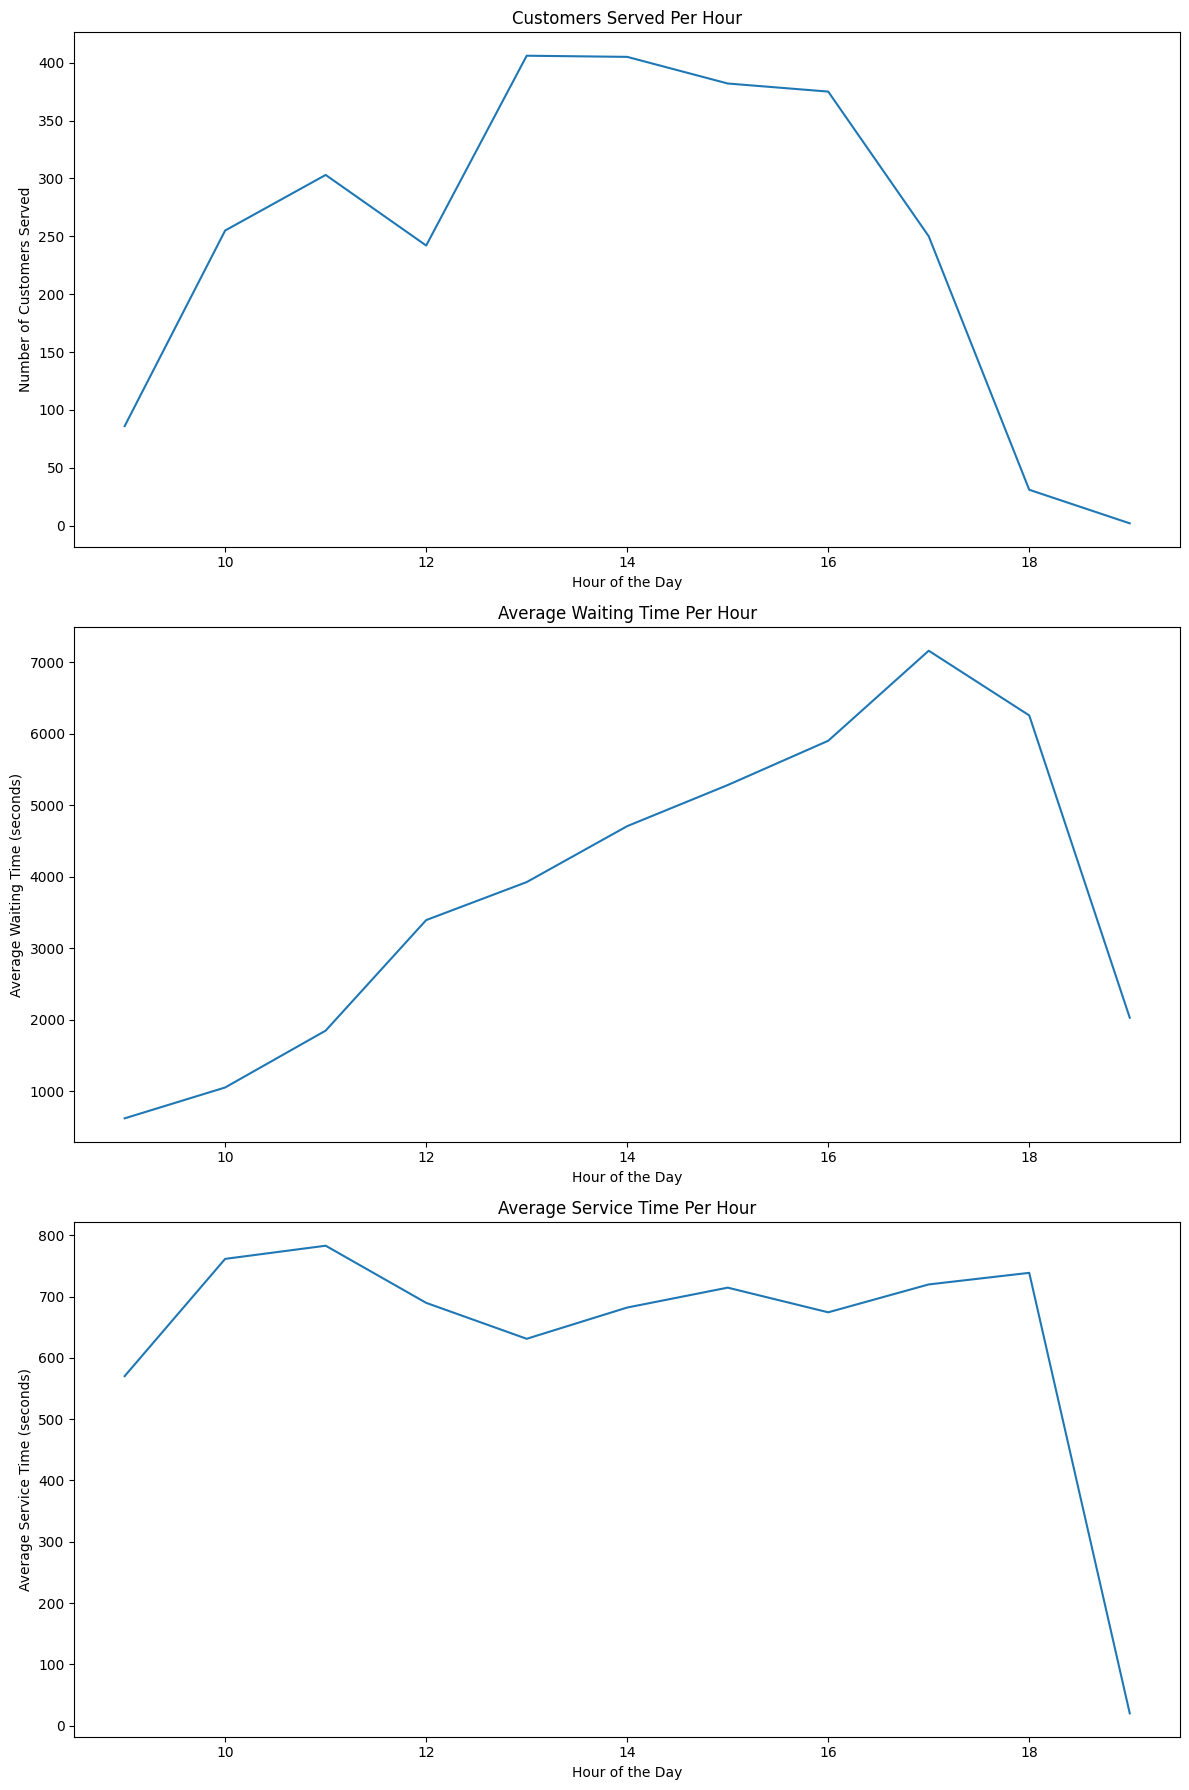

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

sns.lineplot(data=hourly_metrics, x='hour', y='customers_served', ax=axs[0])
axs[0].set_title('Customers Served Per Hour')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Number of Customers Served')

sns.lineplot(data=hourly_metrics, x='hour', y='waiting_time', ax=axs[1])
axs[1].set_title('Average Waiting Time Per Hour')
axs[1].set_xlabel('Hour of the Day')
axs[1].set_ylabel('Average Waiting Time (seconds)')

sns.lineplot(data=hourly_metrics, x='hour', y='service_time', ax=axs[2])
axs[2].set_title('Average Service Time Per Hour')
axs[2].set_xlabel('Hour of the Day')
axs[2].set_ylabel('Average Service Time (seconds)')

plt.tight_layout()
plt.show()
